# The Mandelbrot Set

#### ECE 5760, Fall 2020, Adams/Land

**Note**: Written as a supplement to [Lectures 18, 19, and 20](https://www.youtube.com/playlist?list=PLDqMkB5cbBA4OW0fDTu1FY6aw4uBWOpBa) for the Fall 2020 ECE 5760 course.

In [2]:
from IPython.display import Image
from IPython.core.display import HTML 
import plotly.graph_objects as go
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import pandas as pd
import numpy
import warnings
warnings.filterwarnings('ignore')

## A demo

The demonstration below shows calculation/rendering of the Mandelbrot set using the DE1-SoC. Zooming/panning is done with a mouse, and the visualization toggles to Julia sets with a button press.

<iframe width="560" height="315" src="https://www.youtube.com/embed/INV9DOsudJw" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

## The first goal

The Mandelbrot set is simply too interesting and too lovely to introduce as a set of equations for implementation. So, before we discuss how we'll implement this on the FPGA, I want to first attempt to explain what the Mandelbrot set is and why it's interesting. I'm going to try to do that by following a train of thought similar to that which Benoit Mandelbrot and others (including Hubbard, here at Cornell) were following when they discovered and subsequently explored and sought to understand this structure.

## Thinking about iterations . . .

#### The first iteration we'll consider

The train of thought that leads to the Mandelbrot set begins with thinking about *iterations*. An iteration is simply a rule which we apply over and over again. So, for example, the iteration below tells us to start with some number, $x_0$, and to square it repeatedly. If $x_0$ is 2, then $x_1$ is 4, $x_2$ is 16, etc.

\begin{align}
x_{N+1} &= x_N^2
\end{align}

The question that folks were asking about these iterations was: **for which choices of $x_0$ does this iteration remain *stable* (not go to infinity), and for which choices of $x_0$ does it go to infinity?** Is it obvious that, for this iteration, any $x_0$ in the range [-1,1] is stable, and any $x_0$ outside that range is unstable? We could color the parts of the real number line which are *stable* as shown below.

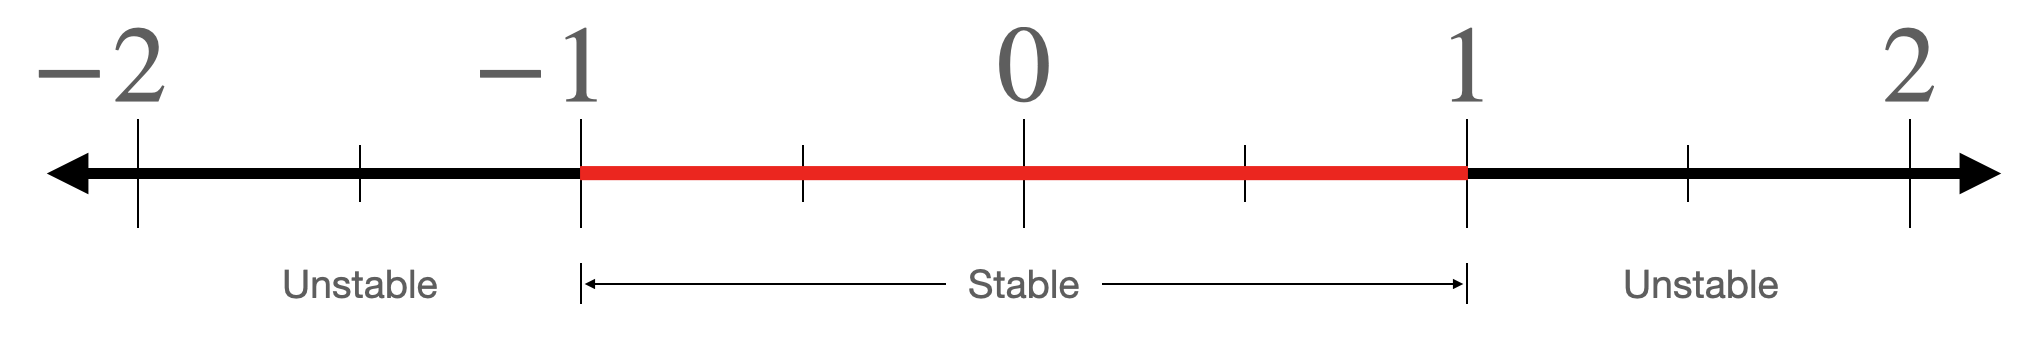

In [46]:
Image(filename = "line.png", width=1000, height=1000)

#### The next iteration we'll consider

Let's consider *almost* the same iteration, except we'll allow for our numbers to be complex. Instead of representing our numbers on the real number line, we represent them in the complex plane. Our numbers can have real parts and imaginary parts.

\begin{align}
z_{N+1} &= z_N^2
\end{align}

As before, the question is: **for which choices of $z_0$ does this iteration remain *stable* (not go to infinity), and for which choices of $z_0$ does it go to infinity?** As many of you will recall, when you square a complex number with magnitude less than one (i.e. a number that is less than one unit from the origin of the complex plane), the resulting complex number has a smaller magnitude. This is the complex extension of the iteration above. So, the region of stability for this iteration is a circle with radius 1 centered at the origin.

Suppose that you couldn't figure out what this region of stability looked like. One strategy that you might deploy in order to get a sense for it might be to populate the complex plane with test points, and then to run the iteration on each of those test points. If you run the iteration some large number of times (say, 1000) and it still hasn't gone above some threshold value (say, 1), then we'll assume that particular point is *inside* the region of stability. If it exceeds some threshold value, we'll assume it's outside the region of stability.

For example, consider the array of test points below. We'll run the above iteration on each of these test points. If the iteration diverges at that point, we'll ignore it. If it converges, we'll mark it with an x. This way, we can get a visual sense for what the region of stability looks like.

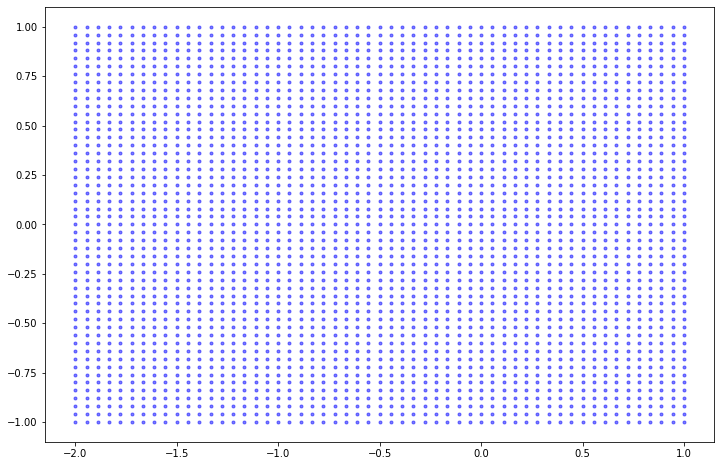

In [2]:
x = numpy.linspace(-2, 1, 55)
y = numpy.linspace(-1, 1, 51)
X, Y = numpy.meshgrid(x, y)
plt.figure(2, figsize=(12, 8))
plt.plot(X, Y, 'b.', alpha=0.5); plt.show()

Run the iteration on each point:

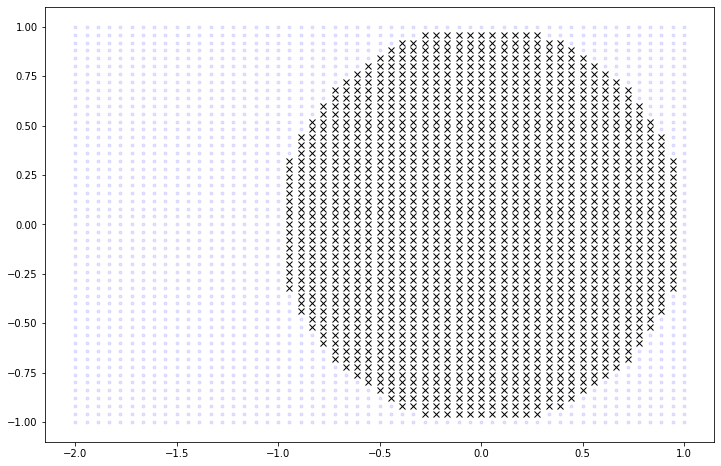

In [3]:
plt.figure(2, figsize=(12, 8))
for i in x:
    for j in y:
        xiter = i
        yiter = j
        newx = xiter
        newy = yiter
        count = 0
        while(count<1000 and (newx**2. + newy**2. < 1)):
            newx = xiter**2. - yiter**2.
            newy = 2*xiter*yiter
            xiter = newx
            yiter = newy
            count += 1
        if (count==1000):
            plt.plot(i, j, marker='x', color='black')
        else:
            plt.plot(i, j, 'b.', alpha=0.1)
plt.show()

As expected, we get a low resolution approximation of a *circle* of radius 1 centered at the origin of the complex plane.

#### One more iteration . . .

Let us now consider an iteration that is *almost* the same as the above iteration. We'll assume that $z_0$ is 0, but we'll add some complex constant $c$ every time we update the iteration. 

\begin{align}
z_{N+1} &= z_N^2 + c \hspace{1cm} \text{where $z_0=0$}
\end{align}

Similar to before, the question is: **for which choices of $c$ does this iteration remain *stable* (not go to infinity), and for which choices of $c$ does it go to infinity?** Like we did for the previous iteration, let us populate the complex plane with test points to attempt to get an understanding for what this region of stability looks like. When we run this iteration for each test point and mark those that converge with an x, we get the following image:

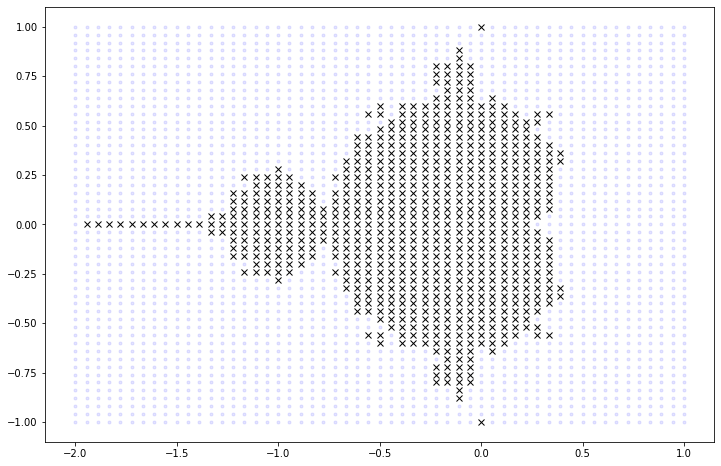

In [4]:
plt.figure(2, figsize=(12, 8))
for i in x:
    for j in y:
        xiter = 0
        yiter = 0
        newx = xiter
        newy = yiter
        count = 0
        while(count<100 and (newx**2. + newy**2. < 4)):
            newx = xiter**2. - yiter**2. + i
            newy = 2*xiter*yiter + j
            xiter = newx
            yiter = newy
            count += 1
        if (count==100):
            plt.plot(i, j, marker='x', color='black')
        else:
            plt.plot(i, j, 'b.', alpha=0.1)
plt.show()

*What the hell is that?* Benoit Mandelbrot would have asked himself the same thing when this came out of the printer in IBM. It is not obvious at this resolution what the edge of this region of convergence looks like. But, in the late 70's, this is the level of resolution that computers were capable of visualizing in reasonable amounts of time. In fact, the first ever published image of the Mandelbrot set is shown below, at approximately the same resolution as it is shown above.

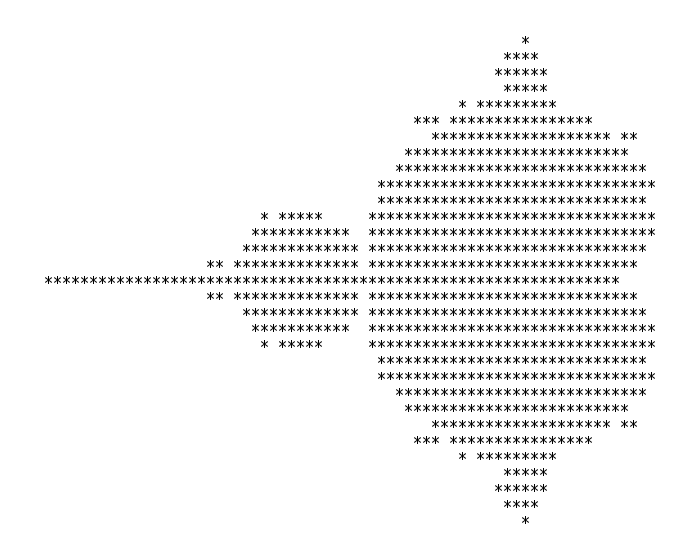

In [5]:
Image(filename = "first.png", width=500, height=500)

As computers became more powerful, this iteration could be run on more and more test points, increasing the resolution for this region of stability. Below is the *same picture*, but with more test points:

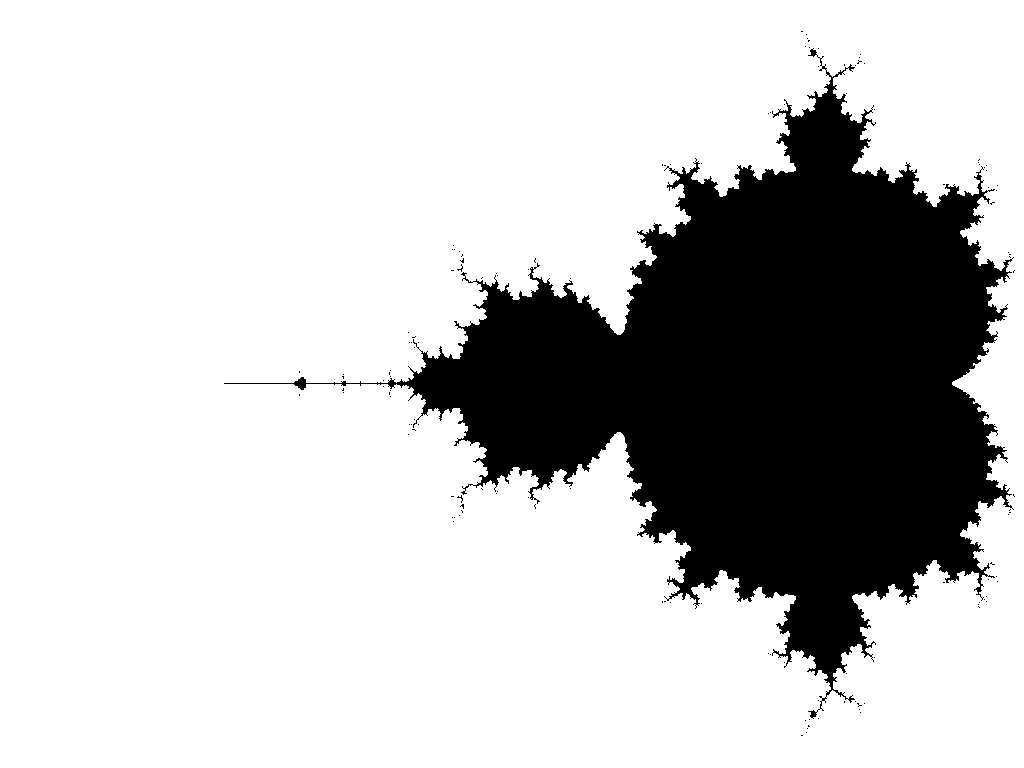

In [6]:
Image(filename = "two.png", width=500, height=500)

Images like the one above have since become some of the most famous in mathematics. Often, you'll see them drawn not just in black and white, but with the unstable points colored in proportion to *how* unstable they are. (Did the point diverge in 2 iterations? If so, color it some color. Did it take 20 iterations? Color it a different color. 500 iterations? A different color again. This colorizations yield images like that shown below:

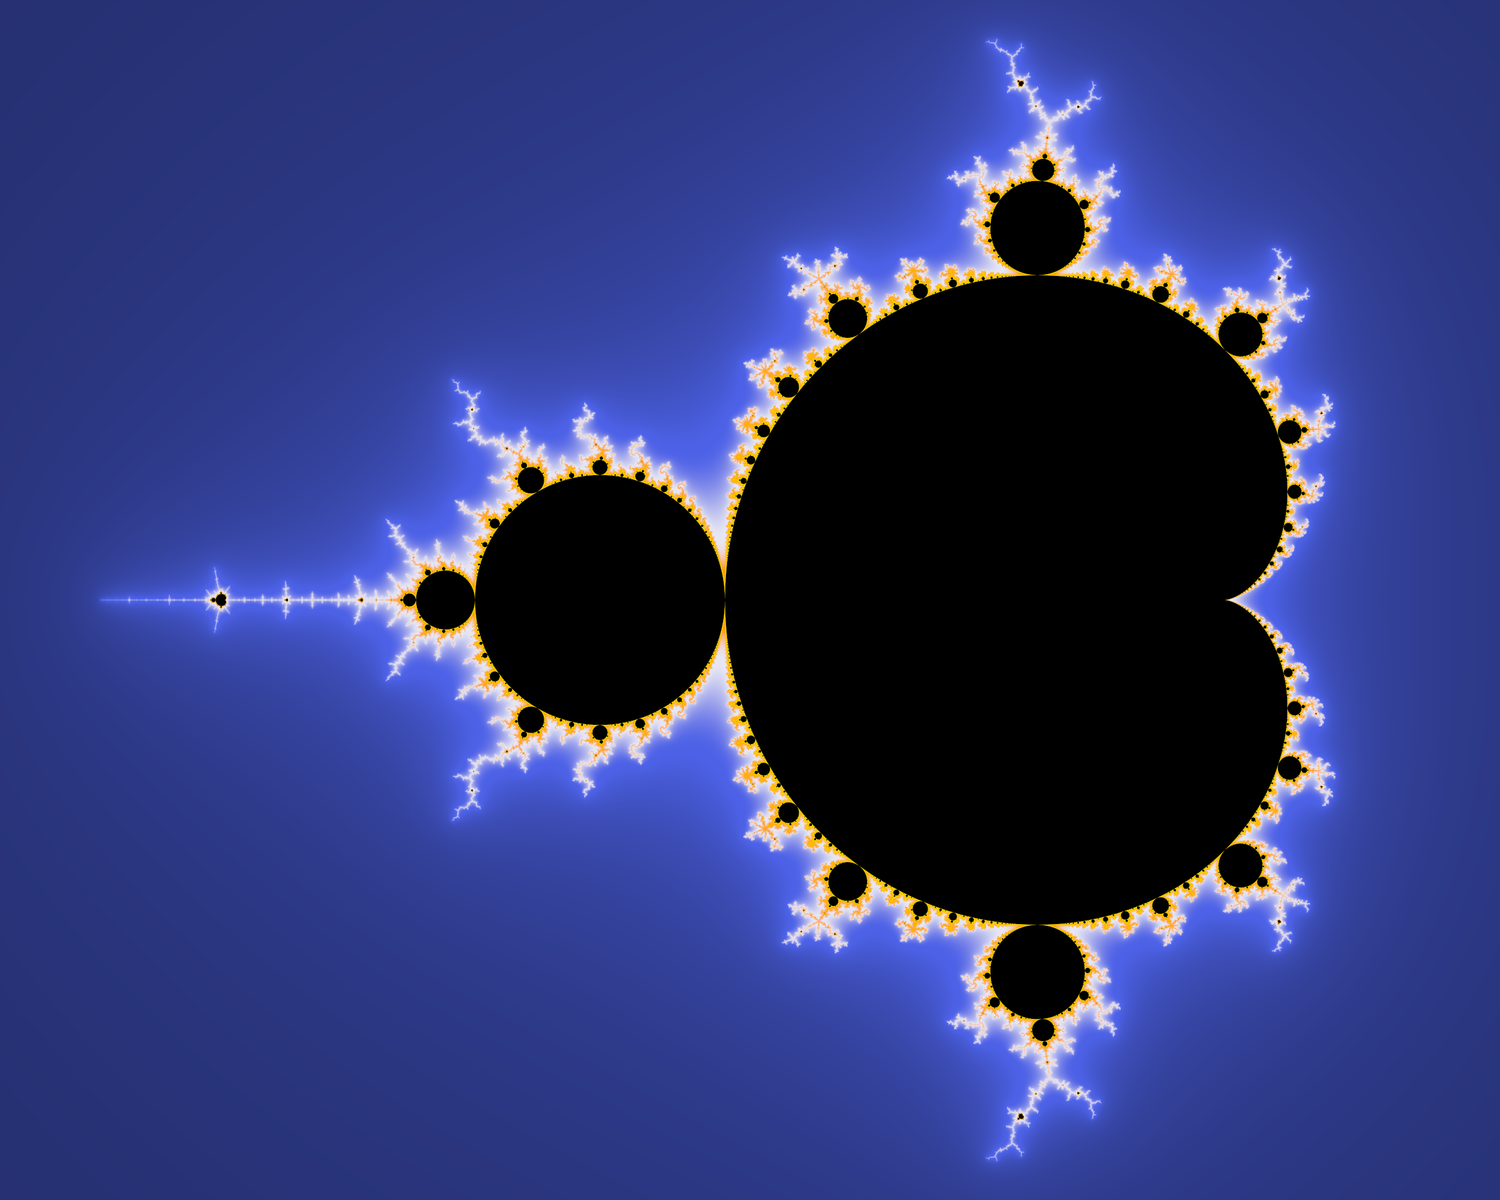

In [7]:
Image(filename = "three.png", width=500, height=500)

## Asking some questions

You look at the image above, and notice that the edge appears rough. The obvious question is "how rough is it?" The answer to that question is, unbelievably, that the edge of the structure is **infinitely rough**. You can zoom in on the edge of the Mandelbrot set **forever** and you will keep finding complex structure. Furthermore, you'll keep finding *new* complex structure. This fractal is not self-similar. As you zoom, you find new things. This means that you can *explore* the Mandelbrot set. You can zoom and pan around the edges of this structure to find things that no human being has ever seen. There is an infinite amount of complexity and beauty contained in the edge of this structure, and all of that complexity is generated from the dead-simple iteration given at the top of this document. Here are some zoomed-in pictures of some places in the edges of the Mandelbrot set:

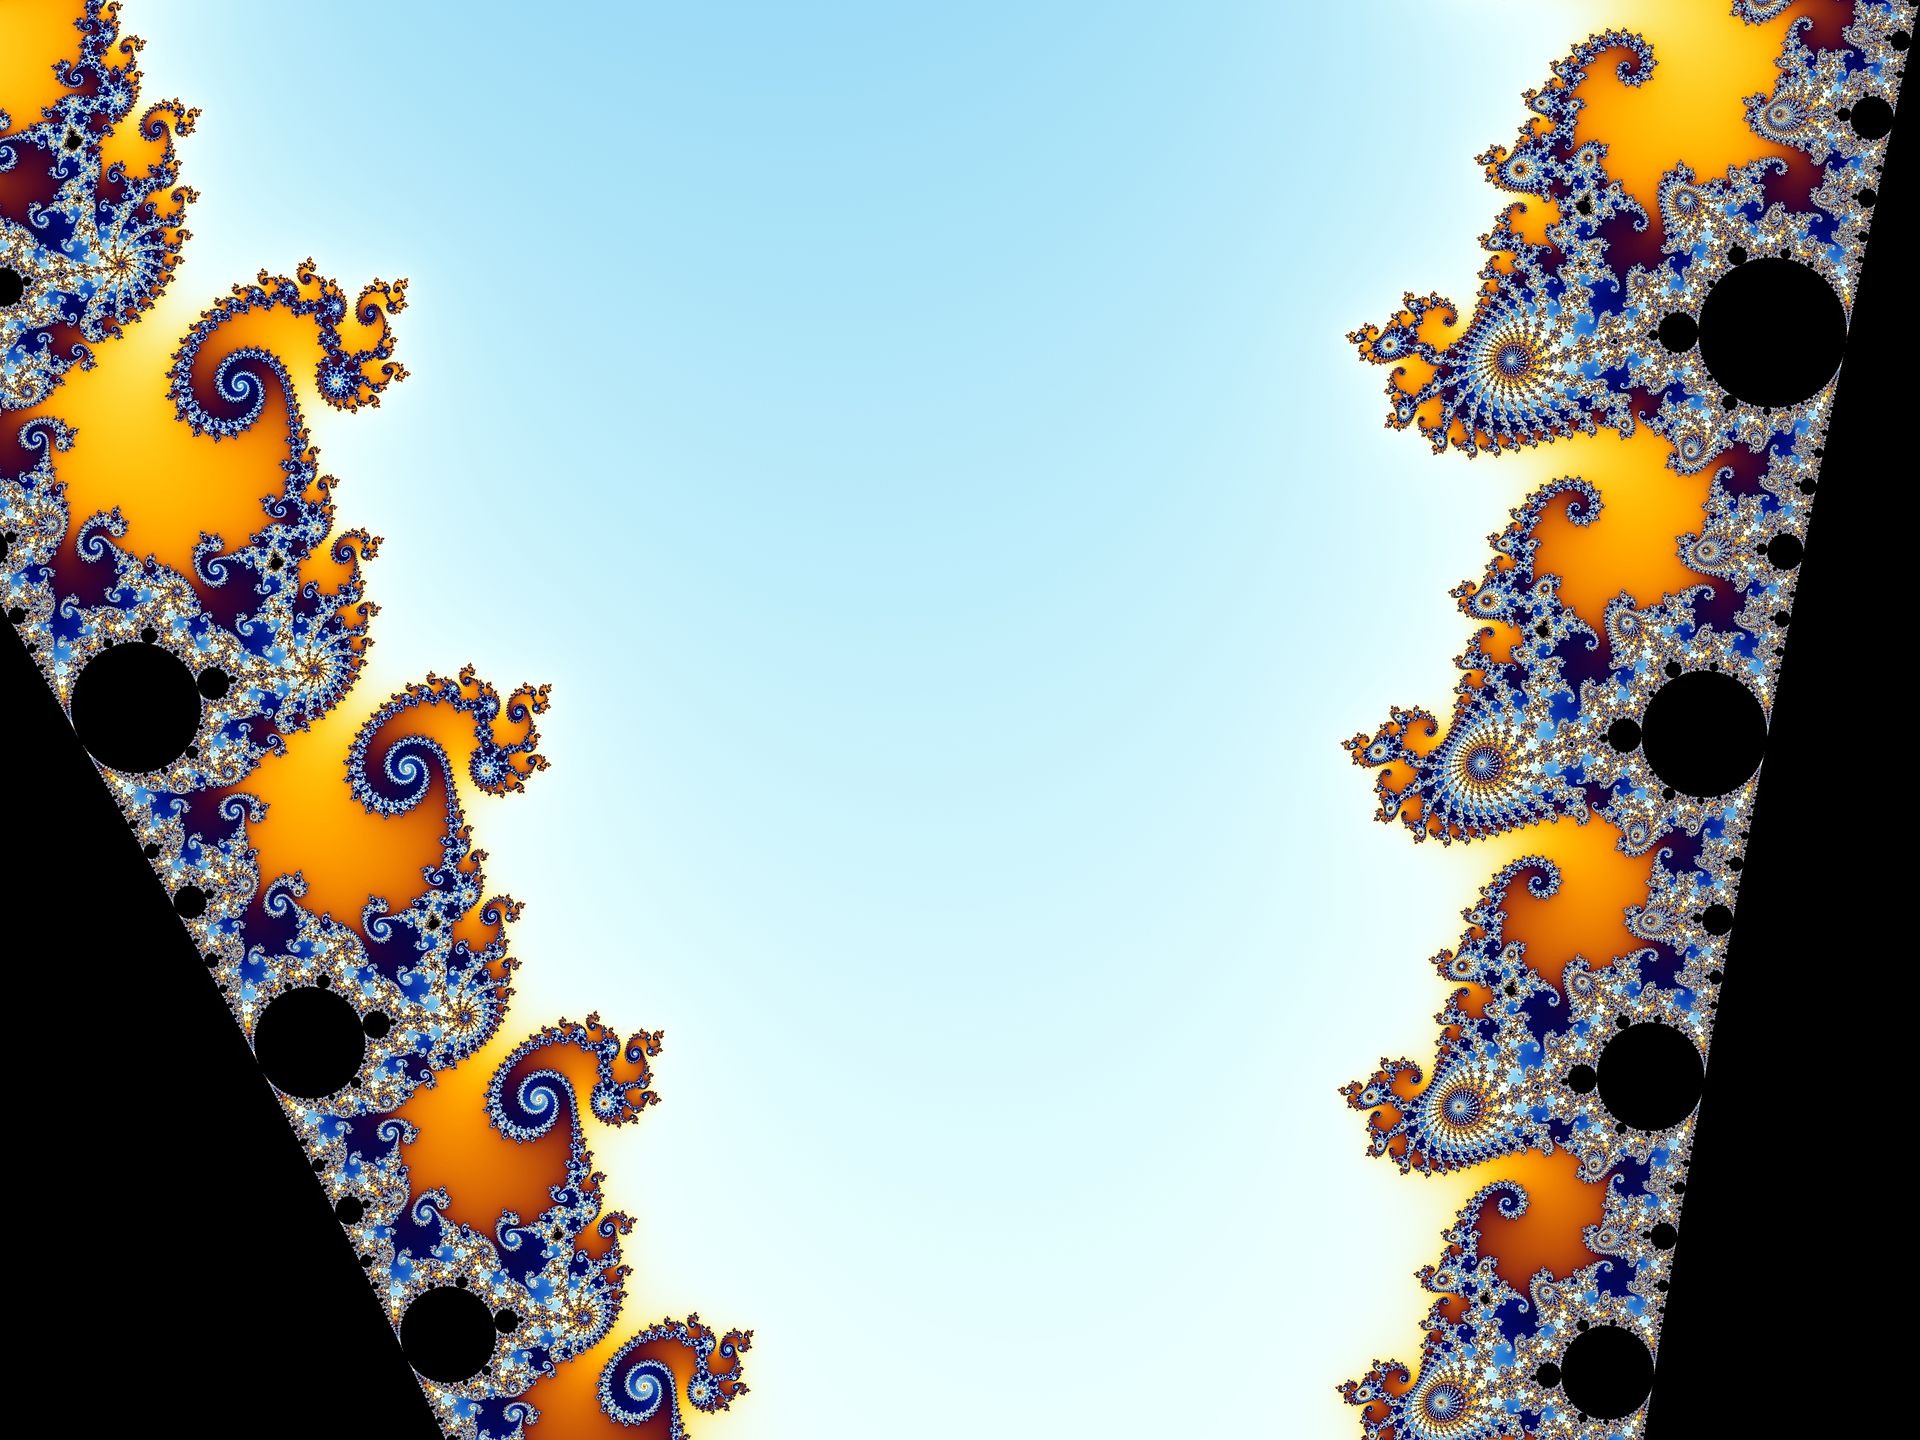

In [8]:
Image(filename = "four.jpg", width=500, height=1000)

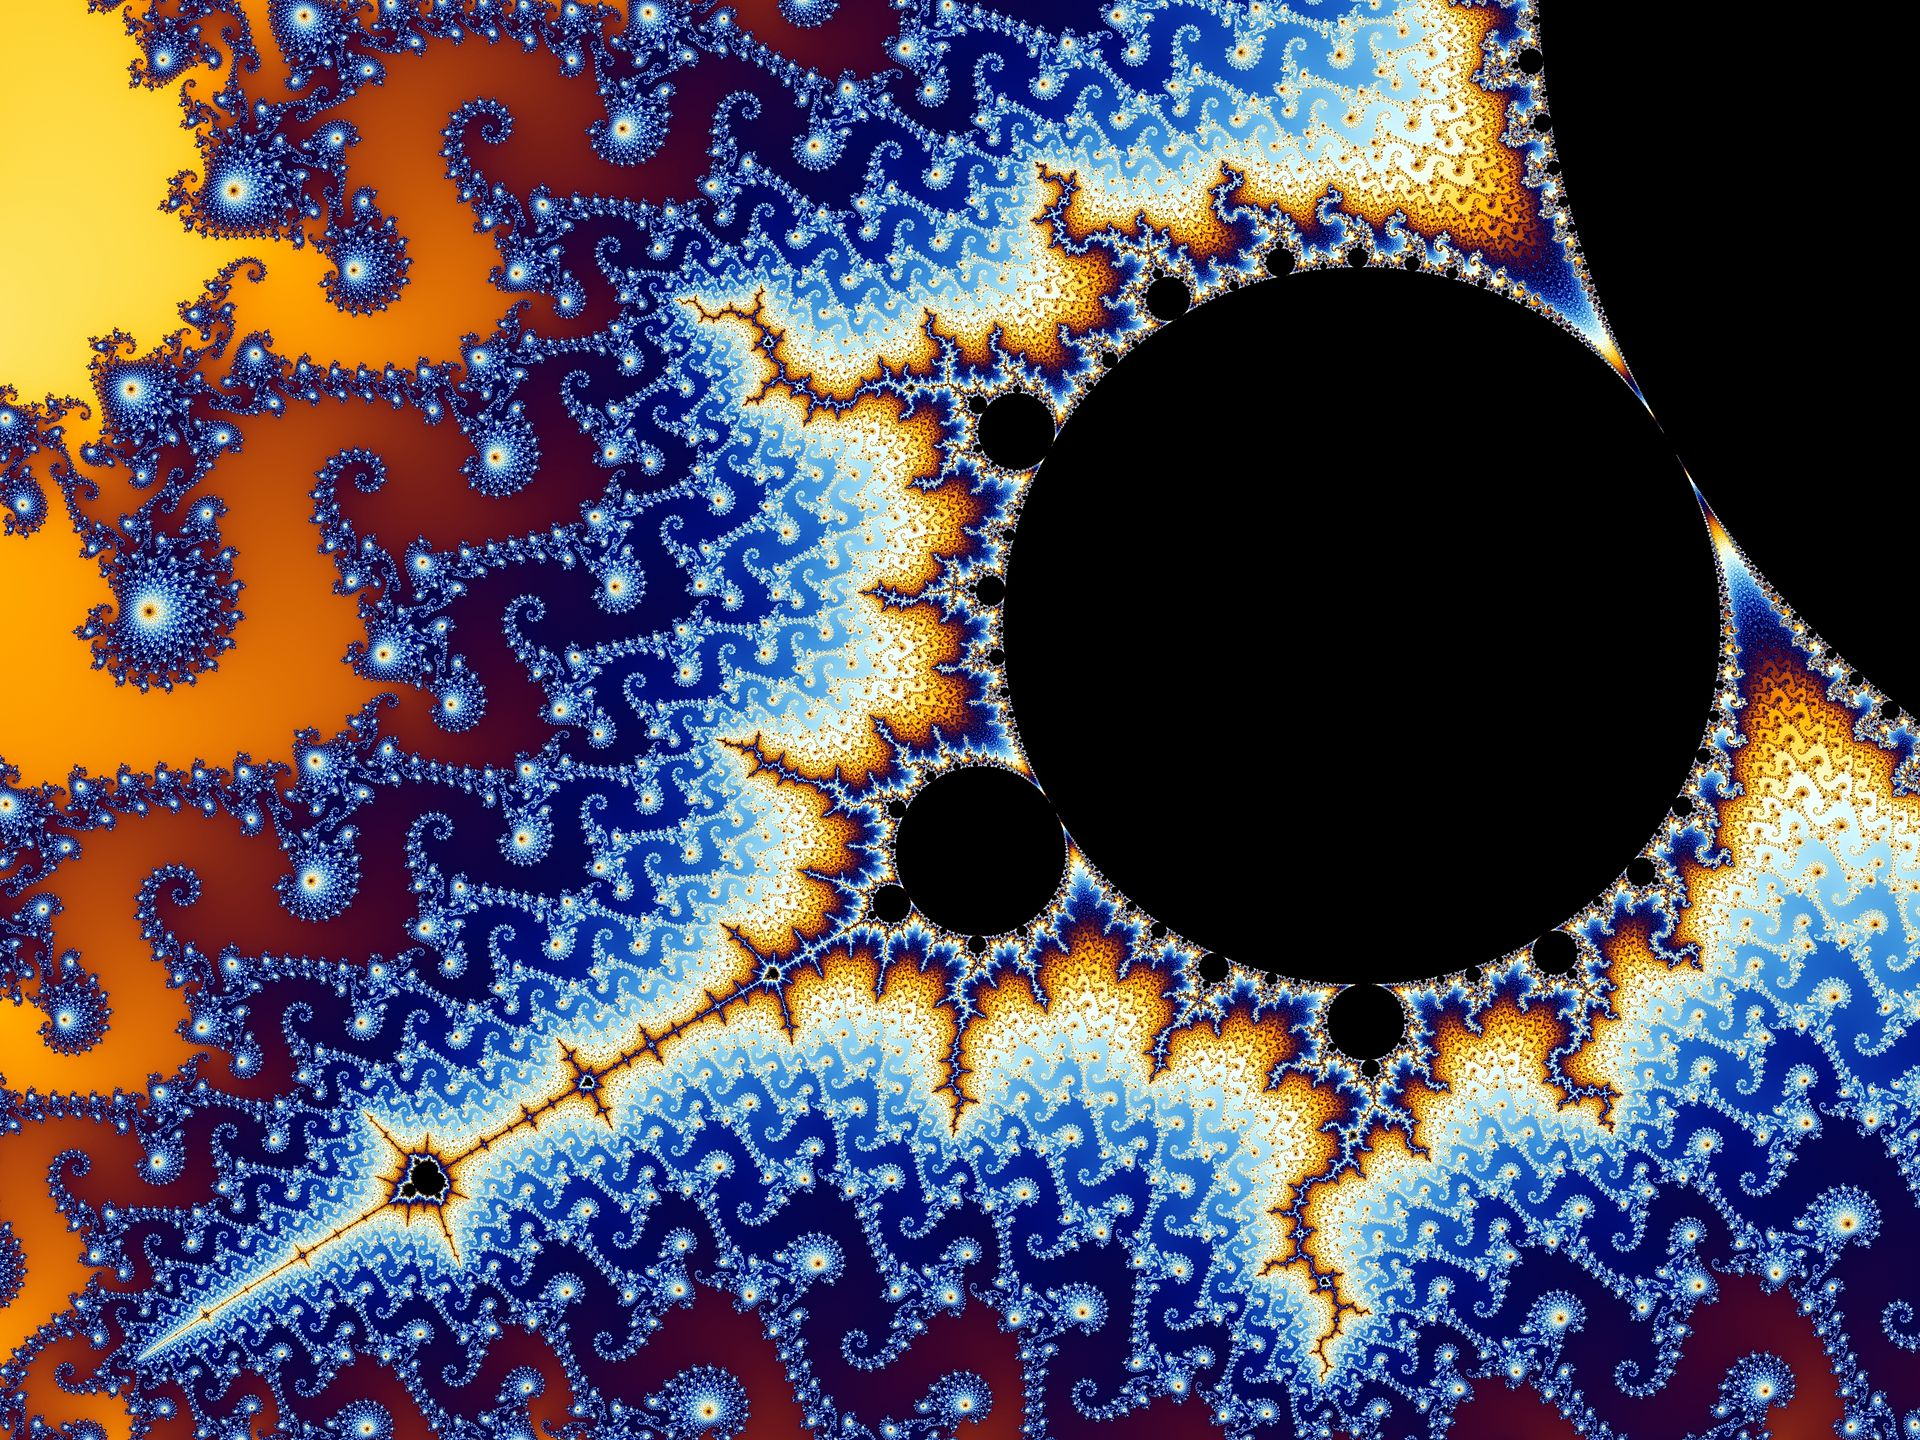

In [9]:
Image(filename = "five.jpg", width=500, height=1000)

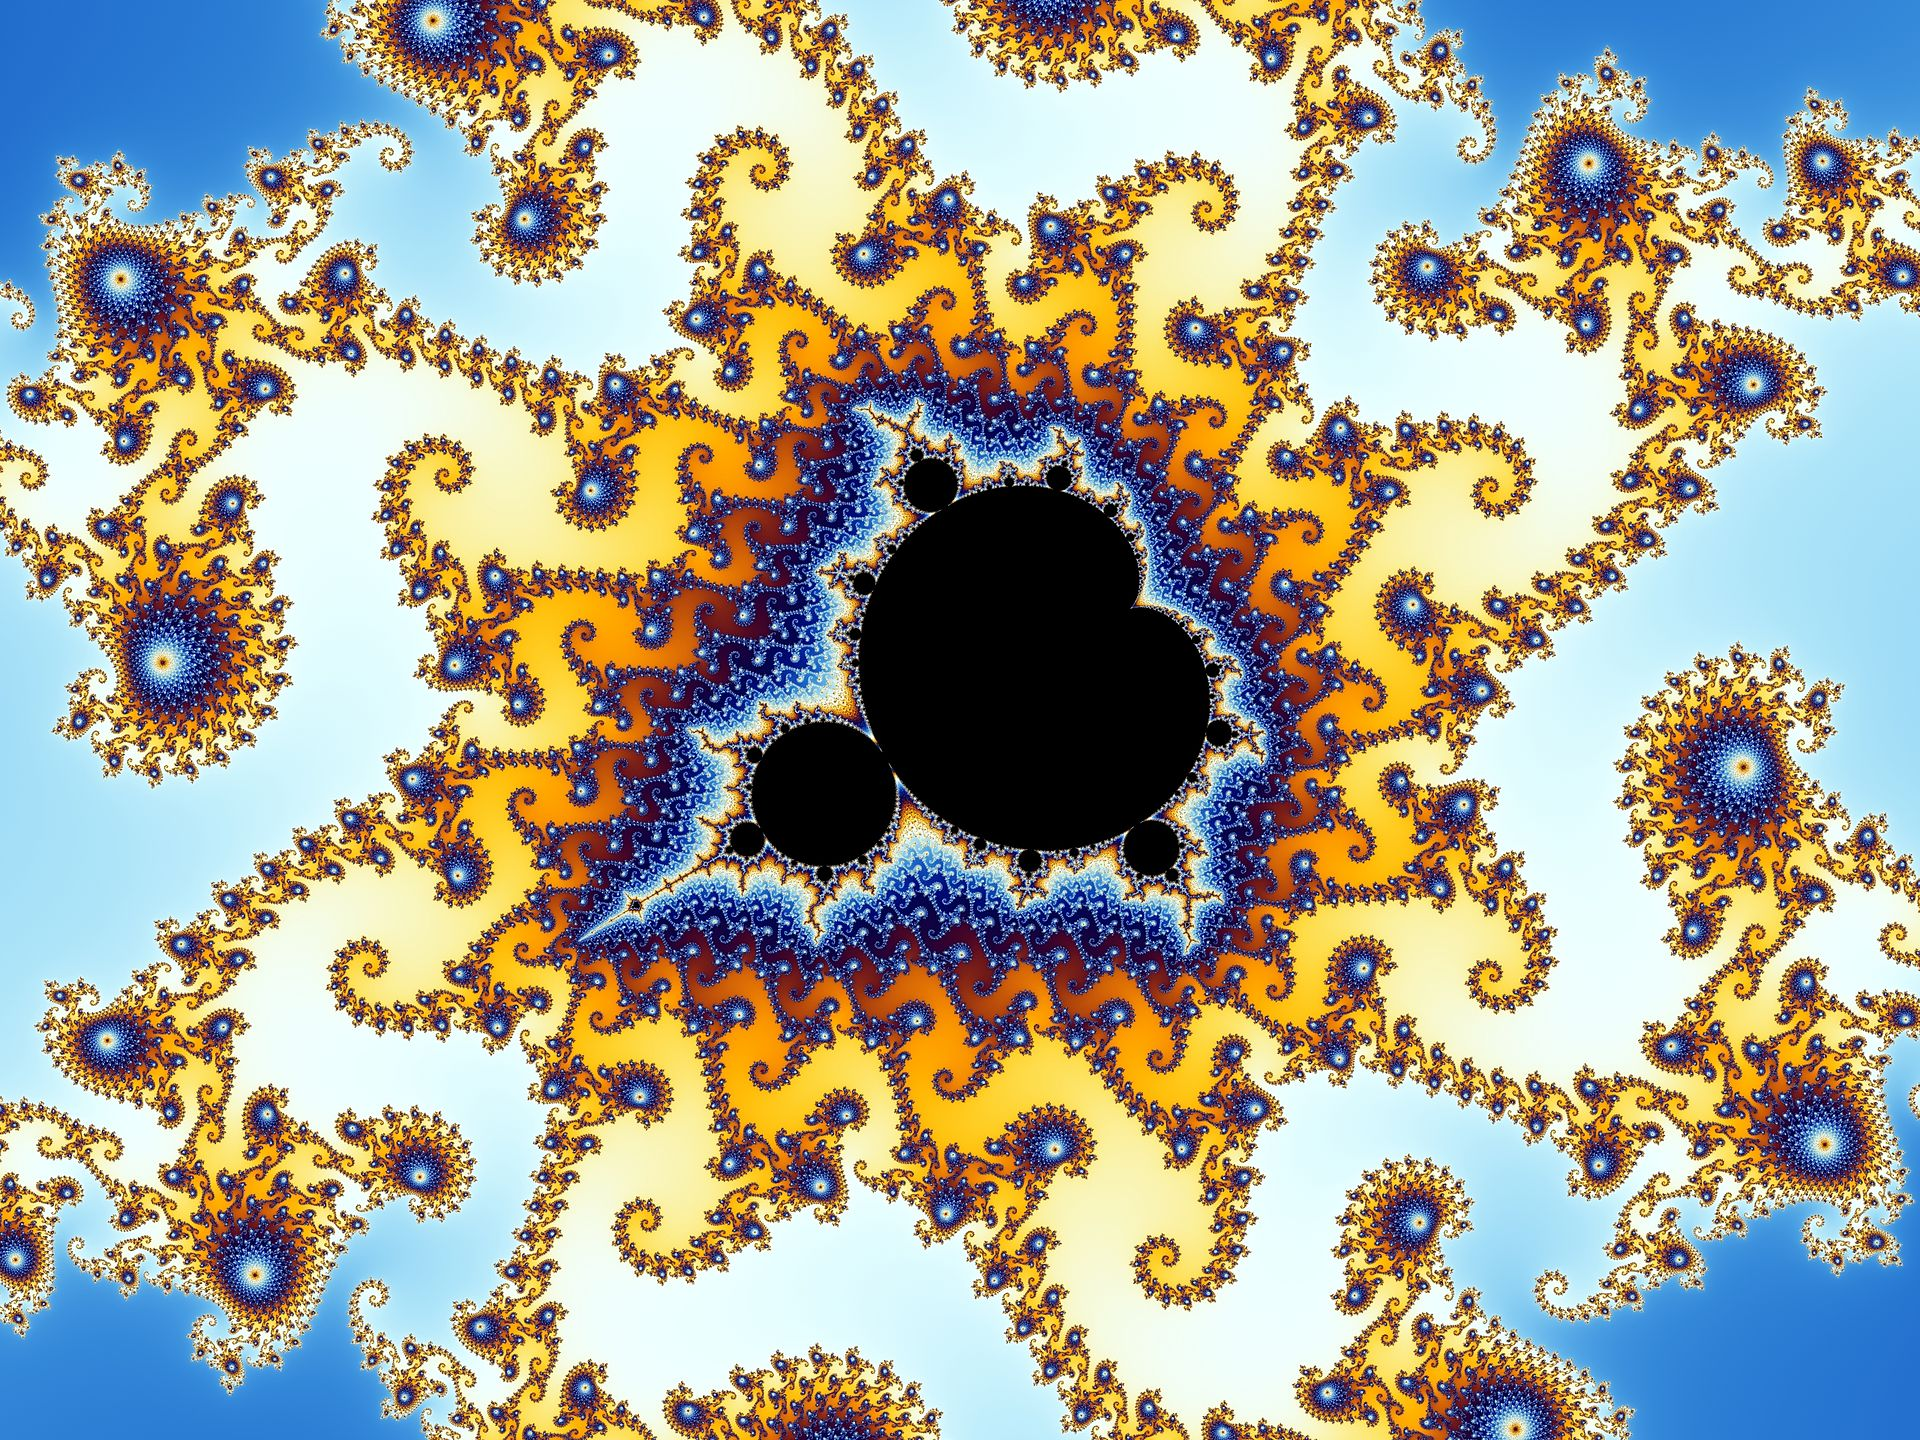

In [10]:
Image(filename = "six.jpg", width=500, height=1000)

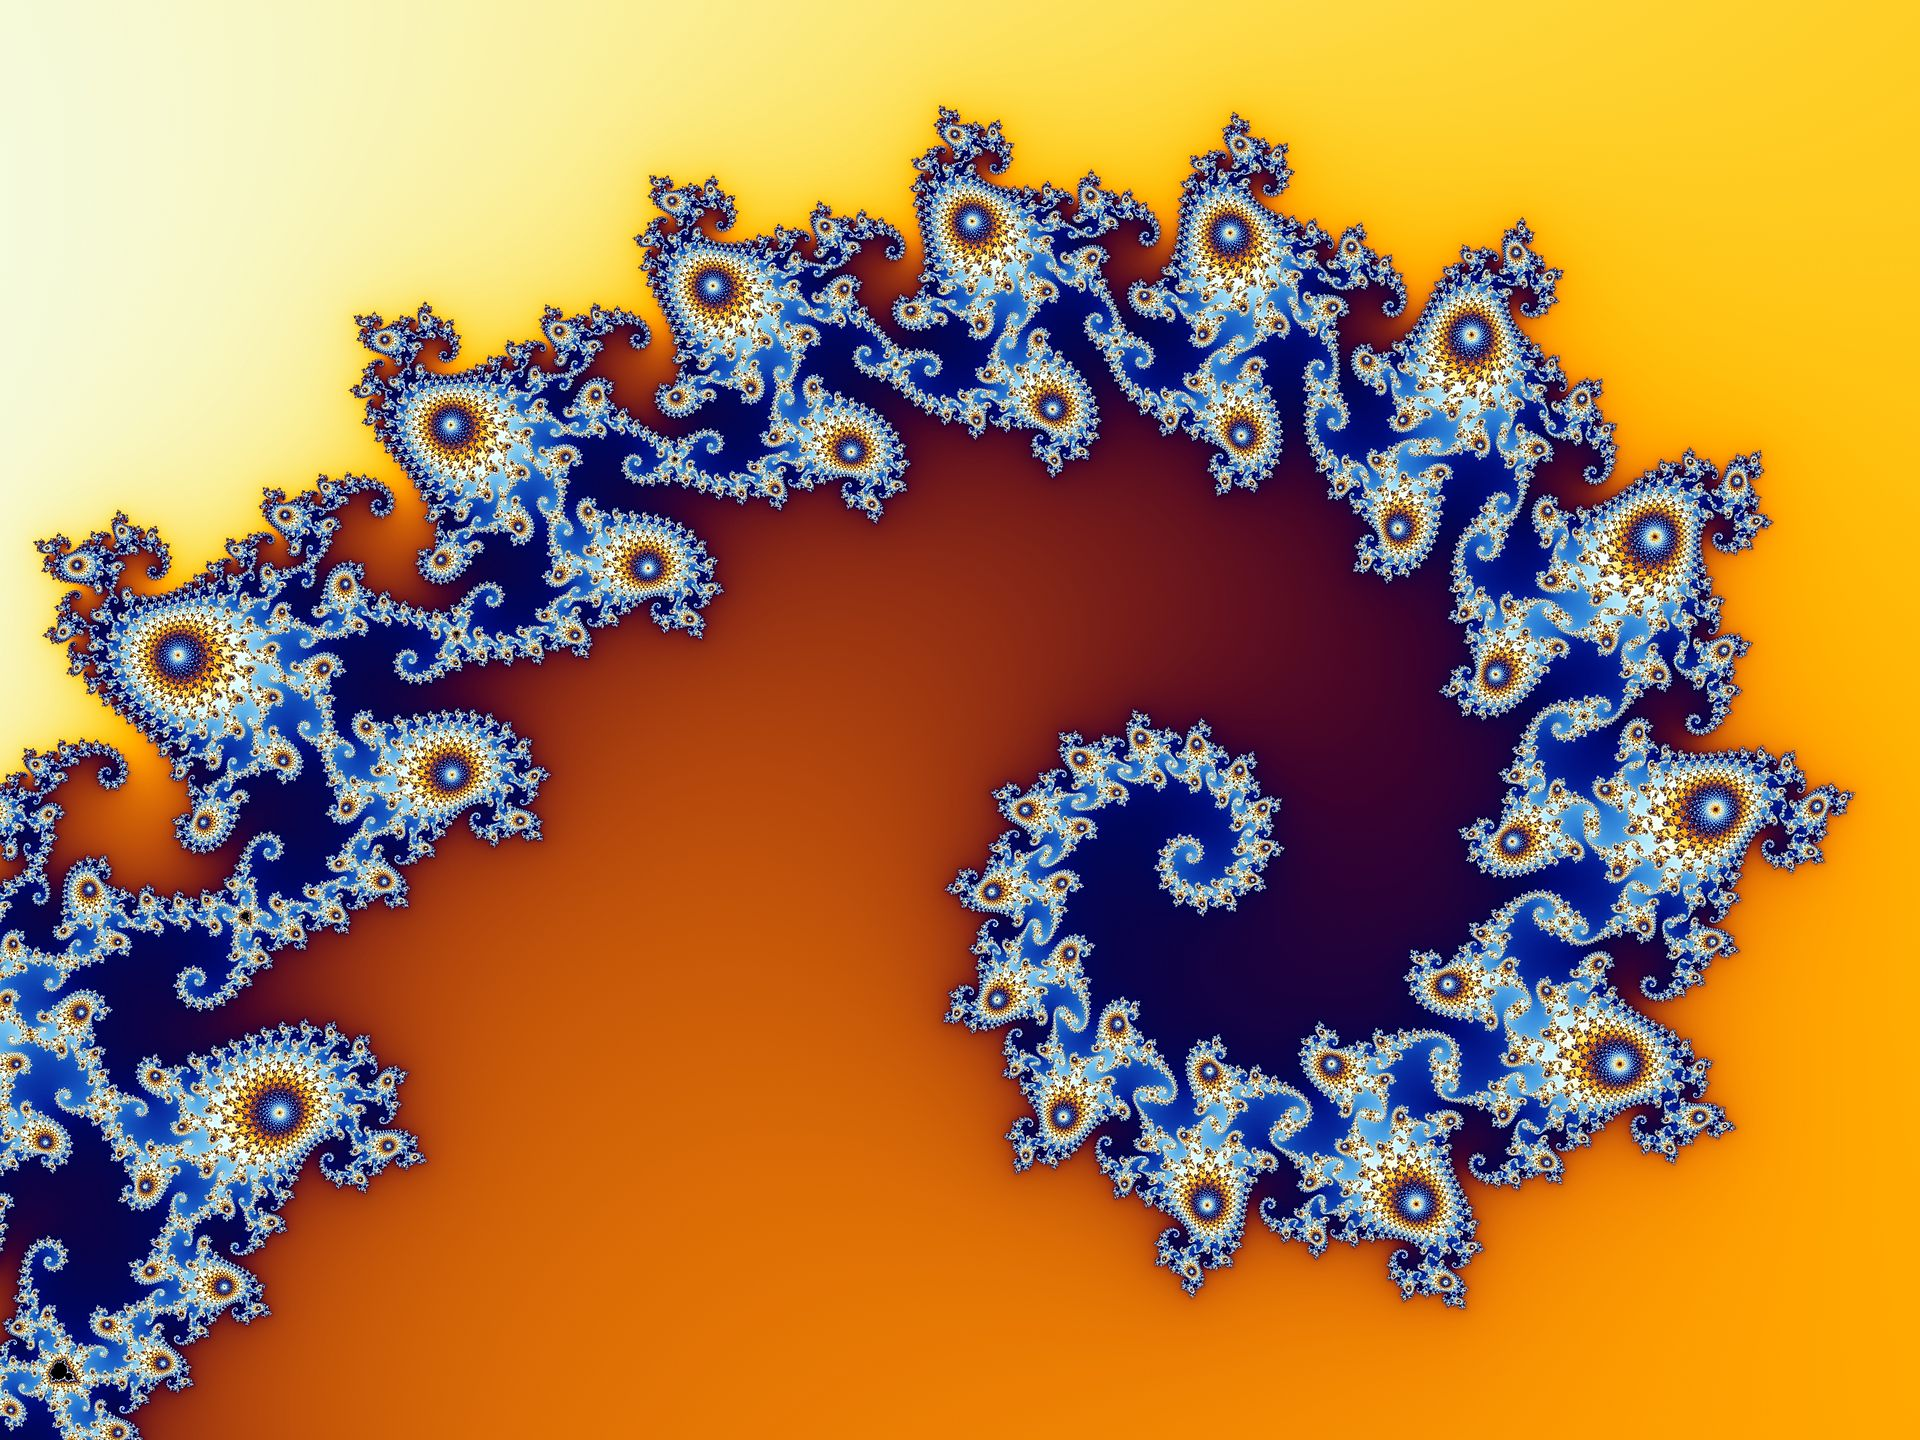

In [11]:
Image(filename = "seven.jpg", width=500, height=1000)

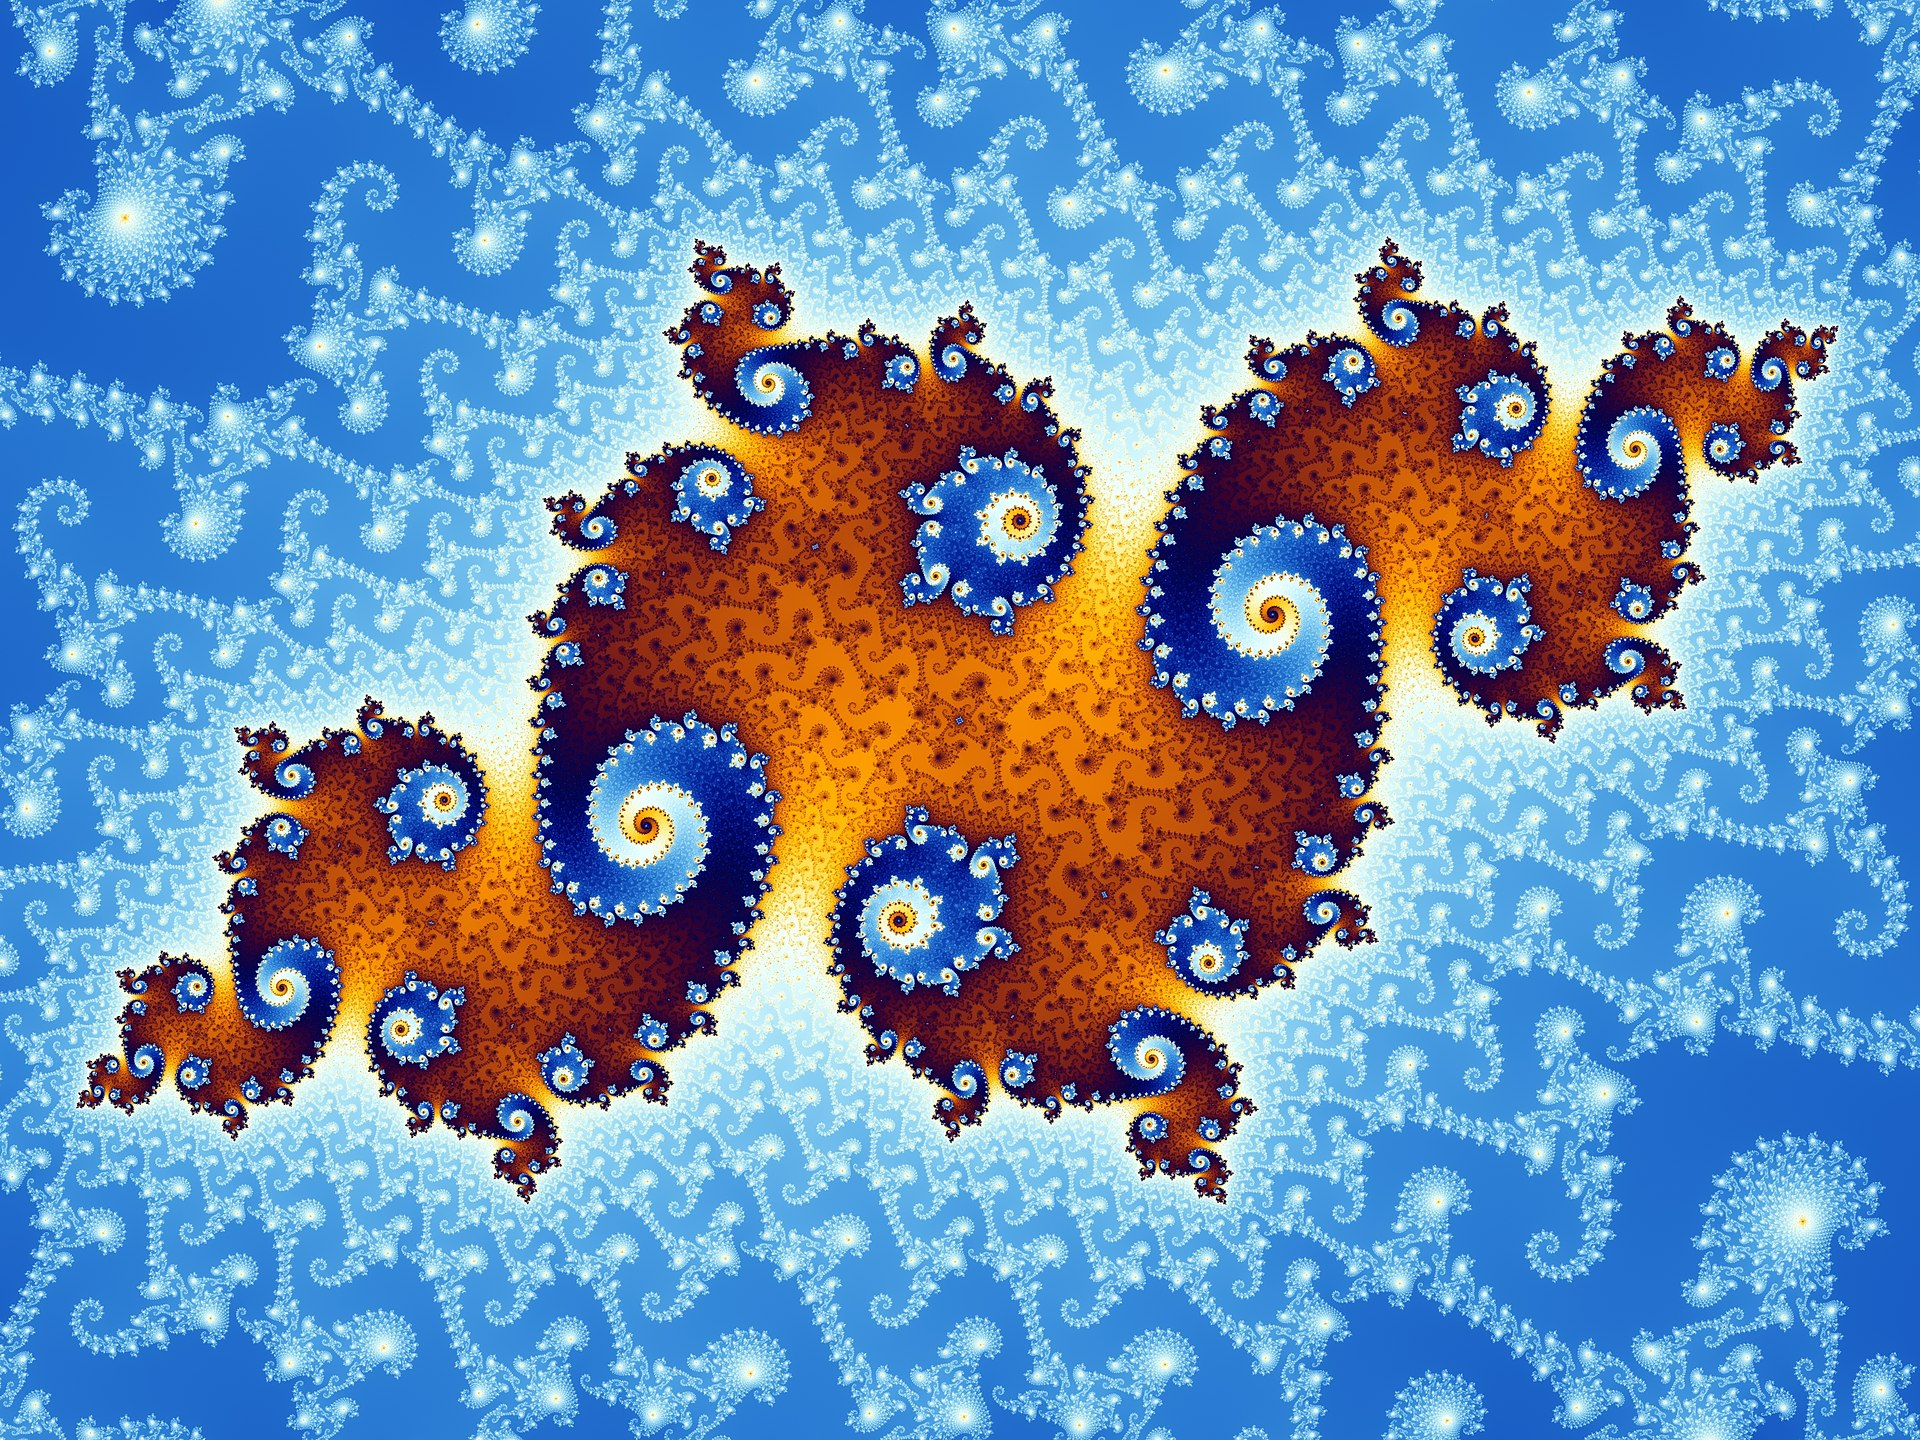

In [12]:
Image(filename = "eight.jpg", width=500, height=1000)

If you google "Mandelbrot Zoom" you'll find about a million videos of falling into the edge of this structure.

## A toy for visualizing these iterations . . .

(Not rendered in HTML. Run the code below in your own Jupyter notebook to generate an interactive plot for visualizing the behavior of the iteration as the complex constant $c$ is moved around the complex plane.)

In [13]:
num=100
def f(Zr, Zi, c, d):
    plt.figure(2, figsize=(10, 10))
    x = list(numpy.zeros(num))
    y = list(numpy.zeros(num))
    x[0] = Zr
    y[0] = Zi
    for i in range(1, num):
        x[i] = x[i-1]**2. - y[i-1]**2. + c*numpy.cos(d)
        y[i] = 2*x[i-1]*y[i-1] + c*numpy.sin(d)
    plt.plot(x, y, 'b-', alpha=0.1)
    plt.plot(numpy.linspace(-1.5, 1.5, 100), numpy.zeros(100), color='black', alpha=0.2)
    plt.plot(numpy.zeros(100), numpy.linspace(-1.5, 1.5, 100), color='black', alpha=0.2)
    plt.plot(x, y, 'r.')
    plt.xlabel('Real', fontsize=18)
    plt.ylabel('Imaginary', fontsize=18)
    plt.plot(c*numpy.cos(d), c*numpy.sin(d), 'b*')
#     circle = numpy.linspace(0, 2*numpy.pi, 100)
#     plt.plot(numpy.cos(circle), numpy.sin(circle))
    plt.plot(x[0], y[0], 'g*')
    plt.ylim(-1.5, 1.5)
    plt.xlim(-1.5 ,1.5)

interactive_plot = interactive(f, Zr=(-2.0, 2.0, .01), Zi=(-2.0, 2.0, .01),
                               c=(0.0, 2.0, 0.01), d=(0.0, 2*numpy.pi, 0.001))
output = interactive_plot.children[-1]
output.layout.height = '600px'
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='Zr', max=2.0, min=-2.0, step=0.01), FloatSlider(valu…

## Lab 3

We are going to be iterating a complex function **a lot**. 

\begin{align}
Z_{N+1} &= Z_N^2 + c\\
Z_0 &= 0
\end{align}

For each choice of $c$, we will determine whether the magnitude of the complex number diverges to infinity or not. If it diverges, it is **outside** the Mandelbrot set. If not, it is inside. So, specifically . . .

1. Choose some threshold number of iterations to test. Say, 1000 (but this will be configurable).
2. Map a particular pixel to a $c$ value (we'll talk about this in a moment)
3. Run the iteration for that particular $c$ value
4. If you reach 1000 iterations without the complex magnitude exceeding 2, assume that point is **in** the Mandelbrot set, and color it accordingly.
5. If $||Z||>2$, assign that pixel a color that maps to the log of the number of iterations that it took to reach 2 (we'll talk about this too).
6. Move on to the next pixel

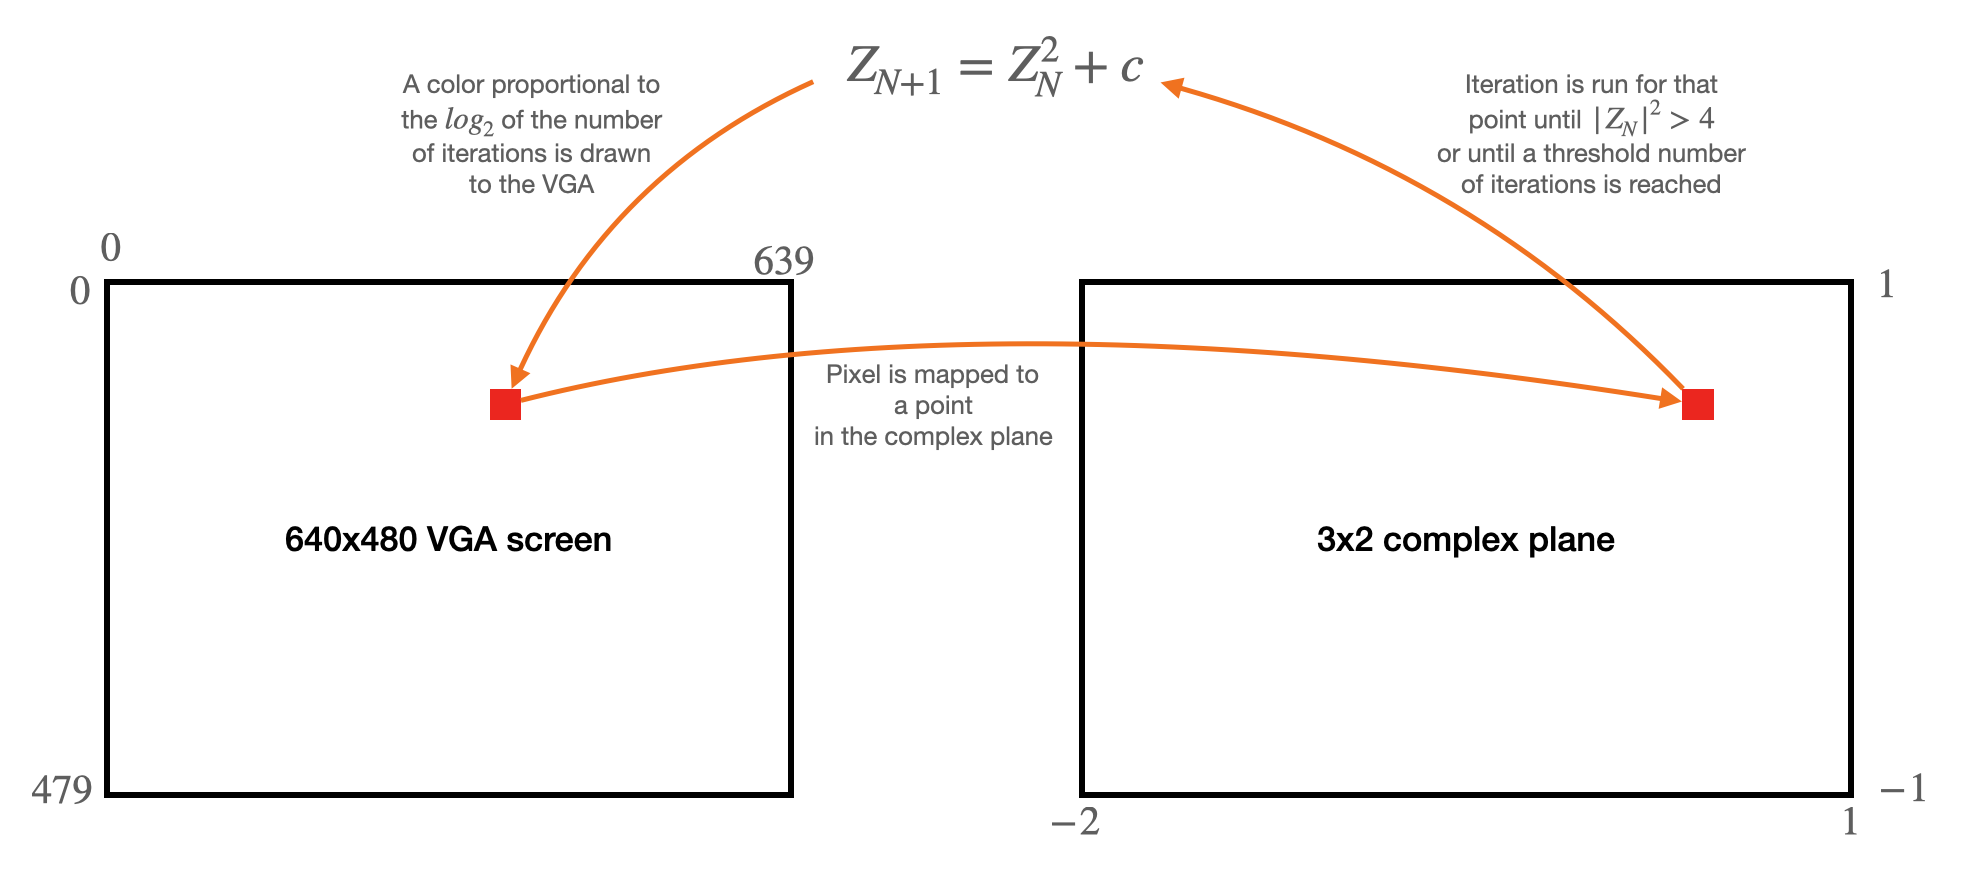

In [33]:
Image(filename = "twoone.png", width=1000, height=1000)

Some things we'll have to think about:

1. Load balancing among all iterators.
2. Serial bottlenecks (how are you going to dispatch pixels to each solver? how are you going to write to the VGA screen from many solvers with limited contention among those solvers?

## Where to start?

As always, start in Matlab or Python.

```matlab
clear all
figure(1); clf;

termination = 100;
x = linspace(-2,1,640);
y = linspace(-1,1,480);
x_index = 1:length(x) ;
y_index = 1:length(y) ;
img = zeros(length(y),length(x));

N_total = 0;
for k=x_index
    for j=y_index
        z = 0;
        n = 0;
        c = x(k)+ y(j)*i ;%complex number
        while (abs(z)<2 && n<termination)
            z = z^2 + c;
            n = n + 1;
            N_total = N_total + 1;
        end
        img(j,k) = log2(n);
    end
end
N_total
imagesc(img)
colormap(jet)
right = 482;
left = 320;
top = 122 ;
line ([left right],[top top],'color','k')
line ([left right],[240+top 240+top],'color','k')
line ([left left],[top 240+top],'color','k')
line ([right right],[top 240+top],'color','k')
x(right);
x(left);
y(top);
```

Matlab abstracts away the complex arithmetic. C and Verilog do not. So, let's briefly review some complex arithmetic:

## Review complex arithmetic

We have the following iteration:

\begin{align}
Z_{N+1} &= Z_N^2 + c\\
Z_0 &= 0
\end{align}

We could expand our iteration into real and imaginary parts:

\begin{align}
Z_R^{N+1} + j Z_i^{N+1} &= (Z_R^N + jZ_i^N)(Z_R^N + jZ_i^N) + C_R + jC_i
\end{align}

We could expand all of this and separate into real and imaginary parts to get the following equations:

\begin{align}
Z_R^{N+1} &= (Z_R^N)^2 - (Z_i^N)^2 + C_R\\
Z_i^{N+1} &= 2Z_R^NZ_i^N + C_i
\end{align}

Once we've calculated $Z_R^{N+1}$ and $Z_i^{N+1}$, we'll determine whether the magnitude of this complex number has exceeded two. (Actually, we'll determine whether the *square* of the magnitude has exceeded 4).

\begin{align}
(Z_R^{N+1})^2 + (Z_i^{N+1})^2 >4 (?)
\end{align}

Save these squared values for the next iteration! You can save yourself half the arithmetic (and 2 multipliers).

## With this arithmetic in mind, consider the hardware

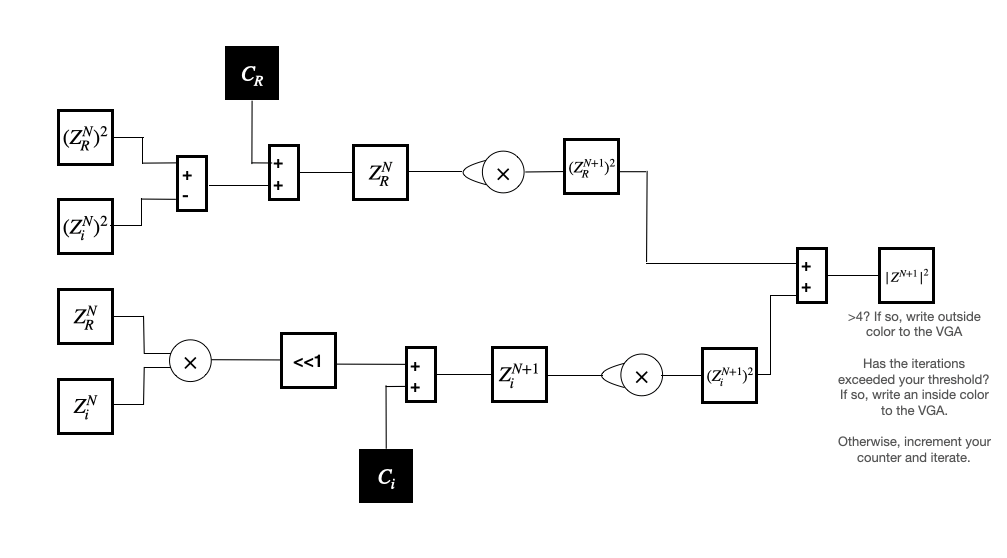

In [6]:
Image(filename = "hw1.png", width=800, height=1000)

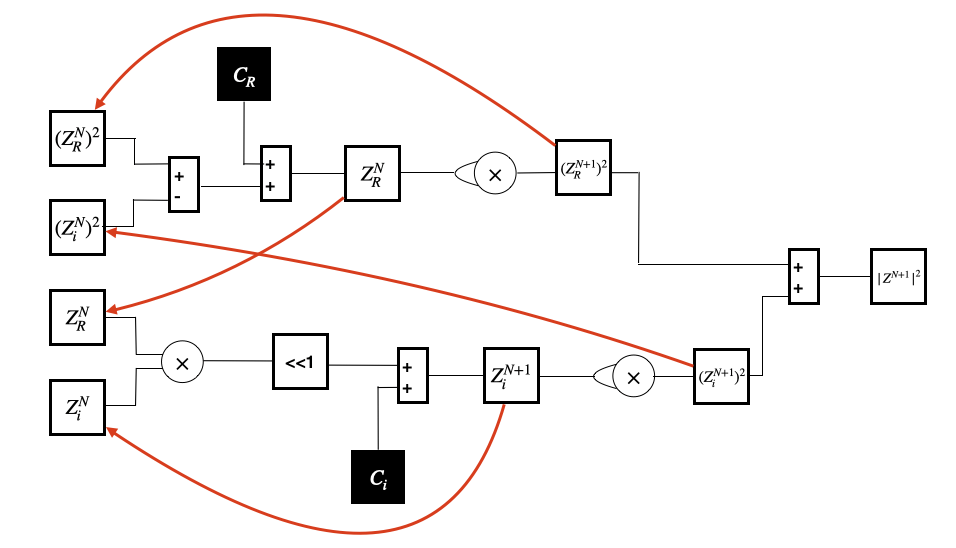

In [8]:
Image(filename = "hw2.png", width=800, height=1000)

## Thinking about load balancing . . .

Which of the below options best balance the load among 4 parallel iterators?

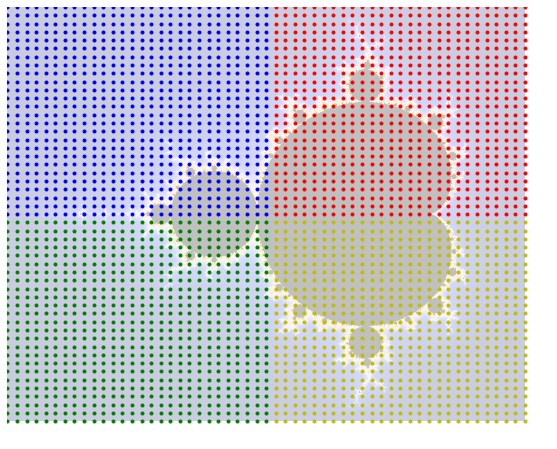

In [32]:
plt.figure(2, figsize=(12, 8))
im = plt.imread('three.png')
implot = plt.imshow(im, zorder=1, alpha=0.25)
for i in range(len(x)):
    for j in range(len(y)):
        if (i<(len(x)/2) and j<((len(y)/2))):
            plt.plot(((x[i]+2)/3.)*1500, ((y[j]+1)/2.)*1200, 'b.', zorder=2)
        elif (i>=(len(x)/2) and j<((len(y)/2))):
            plt.plot(((x[i]+2)/3.)*1500, ((y[j]+1)/2.)*1200, 'r.', zorder=2)
        elif (i<(len(x)/2) and j>=((len(y)/2))):
            plt.plot(((x[i]+2)/3.)*1500, ((y[j]+1)/2.)*1200, 'g.', zorder=2)
        else:
            plt.plot(((x[i]+2)/3.)*1500, ((y[j]+1)/2.)*1200, 'y.', zorder=2)
plt.axis('off')
plt.show()

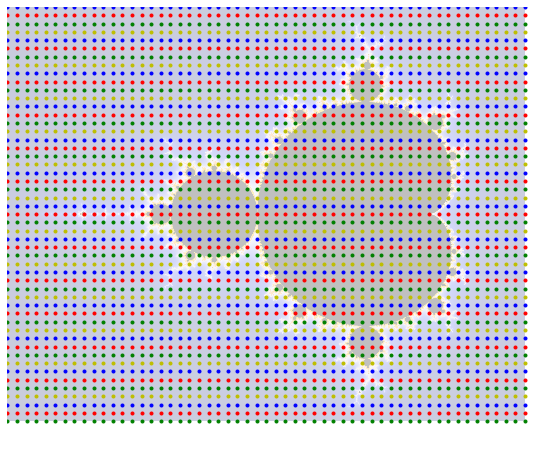

In [30]:
plt.figure(2, figsize=(12, 8))
im = plt.imread('three.png')
implot = plt.imshow(im, zorder=1, alpha=0.25)
for i in range(len(x)):
    for j in range(len(y)):
        if (j%4==0):
            plt.plot(((x[i]+2)/3.)*1500, ((y[j]+1)/2.)*1200, 'b.')
        elif (j%4==1):
            plt.plot(((x[i]+2)/3.)*1500, ((y[j]+1)/2.)*1200, 'r.')
        elif (j%4==2):
            plt.plot(((x[i]+2)/3.)*1500, ((y[j]+1)/2.)*1200, 'g.')
        else:
            plt.plot(((x[i]+2)/3.)*1500, ((y[j]+1)/2.)*1200, 'y.')
plt.axis('off')
plt.show()

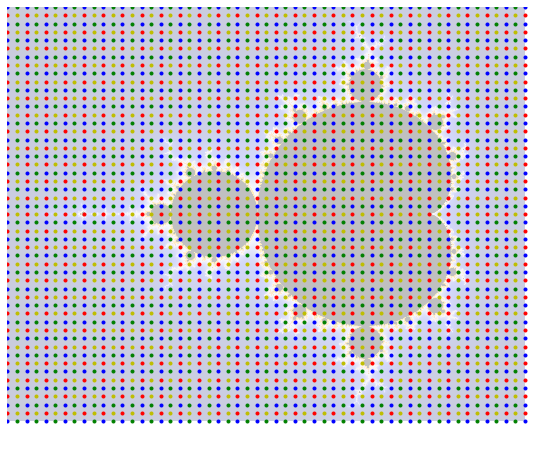

In [28]:
plt.figure(2, figsize=(12, 8))
im = plt.imread('three.png')
implot = plt.imshow(im, zorder=1, alpha=0.25)
for i in range(len(x)):
    for j in range(len(y)):
        if (i%2 == 0):
            if (j%2 == 0):
                plt.plot(((x[i]+2)/3.)*1500, ((y[j]+1)/2.)*1200, 'b.')
            else:
                plt.plot(((x[i]+2)/3.)*1500, ((y[j]+1)/2.)*1200, 'r.')
        else:
            if (j%2 == 0):
                plt.plot(((x[i]+2)/3.)*1500, ((y[j]+1)/2.)*1200, 'g.')
            else:
                plt.plot(((x[i]+2)/3.)*1500, ((y[j]+1)/2.)*1200, 'y.')
plt.axis('off')
plt.show()